<a href="https://colab.research.google.com/github/FHnt97/RUG_TOM_SIO/blob/main/Copy_of_Assignment_A_4_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment A.4 
## Part 2

**Authors:** Group 2.1

*   V. Stupko			S2367246
*   S. Zuidhoek			S4190947
*   R. van der Straten		S3125327	
*   F. Höhne Tarragona		S4605632

**Course:** Smart Industry Operations *EBM223A05.2021-2022.1B*

**Lecturer:** *Dr Christos Emmanouilidis*

***2022-01-14***

<br>

In this part of the assignment, we are asked to classify data into "accept offer", and "don't accept offer" based on historical data. 

We have been given another set of employees which are preselected, and instead of making them a specific offer, we are asking them to request a certain salary level. 
The objective is to analyse whether or not their salary expectations are within reason and will be accepted. 
The 400 rows of trianing data have the column checked - salaries that are within range are accepted (1), salaries outside of range are regected (0). 

The report is divided into sections as follows:
1. Importing op libraries and data
2. Data analysis and basic data clearning
3. Exploraroty analysis of data (correclation analysis)
4. Set-up of classification model - supervised learning
5. Results and conclusion



---



## 1. Importing of libraries and data set

In [147]:
# import all needed libraries

import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px

import matplotlib.pyplot as plt
from sklearn import metrics

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.model_selection import train_test_split



In [39]:
# conenct to drive to access files in the sharedrive 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [121]:
# read csv 
df_train = pd.read_csv('/content/drive/Shareddrives/SIO - Group 2.1 (S1b)/A4 (14.01.2022)/A4_3.csv', sep=',')
df_test = pd.read_csv('/content/drive/Shareddrives/SIO - Group 2.1 (S1b)/A4 (14.01.2022)/A4_4.csv', sep=',')



---


## 2. Initial data analysis and cleaning

For the initial data analysis, we will look solely for extreme discrepancies in the dataset. This includes:
- if needed, removing NaN values
- ensuring the correct Dtype for further data analysis
- if needed, removing outliers in the data (negative values)
- if needed, re-naming attribtues in order to better classify records (gender, department, education level)


This process will be carried out with both the test, and the train dataset.

In [173]:
# check for correct formatting of cells
# check for Na values (no NaNs in dataset therefore no further action is taken)
# df_train.info()
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   RecID                100 non-null    object        
 1   First Name           100 non-null    object        
 2   Surname              100 non-null    object        
 3   Gender               100 non-null    object        
 4   Age                  100 non-null    int64         
 5   Date of birth        100 non-null    datetime64[ns]
 6   Years of experience  100 non-null    int64         
 7   Education Level      100 non-null    int64         
 8   Department           100 non-null    object        
 9   Country              100 non-null    object        
 10  Performance          100 non-null    int64         
 11  EN                   100 non-null    int64         
 12  F                    100 non-null    int64         
 13  SP                   100 non-null   

In [172]:
# change to float 32 to avoid problems with modelling later on 
df_test[df_test.select_dtypes(np.float64).columns] = df_test.select_dtypes(np.float64).astype(np.float32)
df_train[df_train.select_dtypes(np.float64).columns] = df_train.select_dtypes(np.float64).astype(np.float32)

In [123]:
# df_train.columns
df_test.columns

Index(['RecID', 'First Name', 'Surname', 'Gender', 'Age', 'Date of birth',
       'Years of experience', 'Education Level', 'Department', 'Country',
       'Performance', 'EN', 'F', 'SP', 'NL', 'GE', 'IT', 'Assembly',
       'Machining', 'Welding', 'Additive', 'Painting', 'Control', 'Quality',
       'Planning', 'Services', 'Shipping', 'Total'],
      dtype='object')

In [124]:
# change 'Date of birth' to DateTime
df_train['Date of birth'] = pd.to_datetime(df_train['Date of birth'])
df_test['Date of birth'] = pd.to_datetime(df_test['Date of birth'])

In [175]:
# check for consistent input in cells
# df_train.head()
df_test.head()

,RecID,First Name,Surname,Gender,Age,Date of birth,Years of experience,Education Level,Department,Country,Performance,EN,F,SP,NL,GE,IT,Assembly,Machining,Welding,Additive,Painting,Control,Quality,Planning,Services,Shipping,Total
0,1452477EZR,Kenneth,Scholle,male,41,1980-01-07,6,7,operations,Greece,92,0,0,0,1,1,1,1,1,0,1,0,1,1,1,0,1,62943.867188
1,4170288LHS,Harry,Ylonen,male,27,1994-02-12,1,5,operations,Portugal,87,1,0,1,0,1,1,1,0,0,0,0,1,0,1,1,1,54868.234375
2,9897633TAQ,Christopher,Agudo,male,54,1967-04-09,28,5,marketing,France,61,0,1,1,1,1,0,1,0,0,1,1,1,1,0,1,0,81153.960938
3,4288761AQH,Angela,Beckstrom,female,36,1985-01-15,0,7,sales,Finland,13,1,0,0,1,1,1,0,1,0,1,1,1,1,0,0,0,63008.156250
4,8852370IXZ,Mary,Alteri,female,29,1991-12-25,3,8,design,Czech Republic,11,1,0,0,1,0,1,1,0,1,1,0,0,1,1,1,1,59296.593750


In [126]:
# add 'Check' column to df_test and fill with 0 
df_test.Check = np.nan

In [127]:
# gender needs to be made consistent 
df_train = df_train.replace({'Gender': {'f': 'female', 'm': 'male'}})
df_test = df_test.replace({'Gender': {'f': 'female', 'm': 'male'}})

In [174]:
# check for no negative values/ alomalies in numeric columns
#df_train.describe()
df_test.describe()

,Age,Years of experience,Education Level,Performance,EN,F,SP,NL,GE,IT,Assembly,Machining,Welding,Additive,Painting,Control,Quality,Planning,Services,Shipping,Total
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.00,100.00,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,44.140000,9.940000,5.830000,57.180000,0.480000,0.45,0.55,0.610000,0.480000,0.480000,0.600000,0.420000,0.490000,0.560000,0.500000,0.520000,0.480000,0.530000,0.510000,0.520000,62407.734375
std,14.618392,8.361552,1.442886,28.853647,0.502117,0.50,0.50,0.490207,0.502117,0.502117,0.492366,0.496045,0.502418,0.498888,0.502519,0.502117,0.502117,0.501614,0.502418,0.502117,11823.677734
min,18.000000,0.000000,4.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,41081.464844
25%,32.500000,1.000000,5.000000,36.750000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,52290.206055
50%,44.500000,9.500000,6.000000,60.500000,0.000000,0.00,1.00,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.500000,1.000000,0.000000,1.000000,1.000000,1.000000,61056.589844
75%,57.250000,15.250000,7.000000,81.750000,1.000000,1.00,1.00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,71846.072266
max,67.000000,31.000000,8.000000,100.000000,1.000000,1.00,1.00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,87165.789062


In [129]:
# check number of departments 
df_train.Department.unique()
df_test.Department.unique()

array(['operations', 'marketing', 'sales', 'design', 'purchasing',
       'innovation', 'finance'], dtype=object)

In [130]:
# check number of education levels 
df_train['Education Level'].unique()
df_test['Education Level'].unique()

array([7, 5, 8, 4, 6])

## 3. Exploratory analysis of data

As only datapoints with a 1 are accpeted, these will be filtered out for the exploratory analysis of the data (we are trying to find a pattern in why a specific offer is accepted).

We start the exploratory analysis with the following hypotheses:
- **H1: Salary is strongly correlated with the perfromance score**
- **H2: Salary is correlated with the level of education** 
-  **H3: Salary trends change for each department**

The exploratory data analysis has been divided into two parts:

1.   Distribution analysis through histogramms and scatter plots (using a pair plot)
2.   Correlation analysis


The objective of this analysis is to find attributes by which the different data points can be classified.
This classification will later on allow us to reject or accept a salary offer. 

**Specific attributes, namely gender, age, and coutnry of residency, are purposefully NOT going to be analysed/included in the classifications, as these attributes should NOT have an influence on the assigned total salary, even if the historical data indicates a correlation or trend.**


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



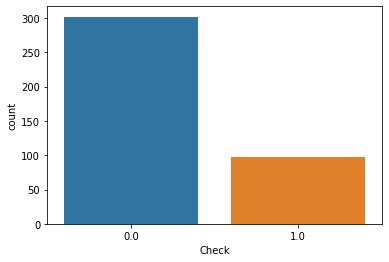

In [176]:
# proportion of salary offers accepted
sns.countplot(df_train['Check'])

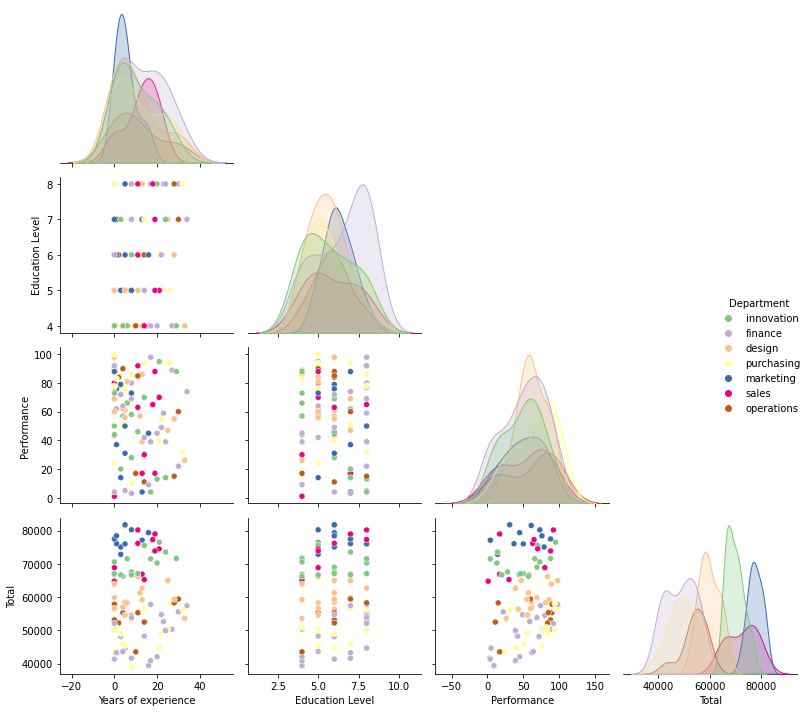

In [177]:
# Proving H1 and 2 --> plot numerical attributes that might have a relationship with 'Total'
# Proving H3 --> colour coordinate by department 
cols = ['Years of experience','Education Level', 'Department', 'Performance', 'Total']
df = df_train.loc[df_train['Check']== 1]

sns.pairplot(df[cols], hue = 'Department', palette='Accent', corner=True, height=2.5)
plt.tight_layout()

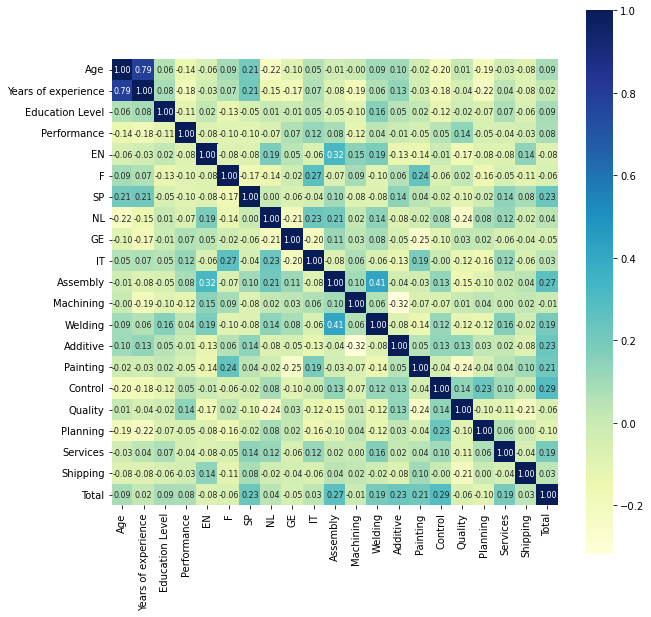

In [178]:
%matplotlib inline
#showing correlation among variables
df = df.drop('Check', axis=1)
fig, ax = plt.subplots(figsize=(10,10))  
corr = df.corr('spearman')
sns.heatmap(corr, 
            cbar=True,
            annot=True, 
            square=True,
            fmt='.2f',
            annot_kws={'size': 8},
            cmap='YlGnBu')


When looking at the pairpot, we see H3 is correct:
- We can see a multimodal distribution when looking at the histogram for Total. From said Histogram, **we see that some colours/ departments have an overall higher 'Total' than the other Departments.**  

Looking at the correlation diagram, we see that H1 and H2 are also correct: 

*   **there is a positive correlation between Total and Perfromance**
*   **there is a positive correlation between Total and Education Level**

Additionally, there is also a stron positive correlation between Years of experience and Total. 

A first classification step should therefore be dividing candidates by department. 


## 4. Supervised learning

In [183]:
# using the train dataset, drop any columns which are not needed for the model, and split into test and train data
lst_dep = df_train.Department.unique()
df_dep = df_train.loc[df_train['Department']== lst_dep[0]]

df = df_dep[['Years of experience', 'Education Level', 
       'Performance', 'EN', 'F', 'SP', 'NL', 'GE', 'IT', 'Assembly',
       'Machining', 'Welding', 'Additive', 'Painting', 'Control', 'Quality',
       'Planning', 'Services', 'Shipping', 'Total', 'Check']]

In [193]:
X = df.drop('Check', axis=1)
y = df['Check']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

### RANDOM FOREST

In [194]:
# random forest
rfc = RandomForestClassifier(n_estimators=200)
rfc.fit(X_train, y_train)
predictions = rfc.predict(X_test)

In [195]:
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

[[9 0]
 [2 0]]
              precision    recall  f1-score   support

         0.0       0.82      1.00      0.90         9
         1.0       0.00      0.00      0.00         2

    accuracy                           0.82        11
   macro avg       0.41      0.50      0.45        11
weighted avg       0.67      0.82      0.74        11



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



### LINEAR MODEL

In [196]:
logisticreg = LogisticRegression()
logisticreg.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegression()

In [197]:
y_pred = logisticreg.predict(X_test)
accuracy = logisticreg.score(X_test, y_test)

In [198]:
accuracy

0.8181818181818182

## 5. Results & conclusion

For this part, we first need to prepare the test dataset, then apply the ML algortihm, and finally, re-set the testing dataset to it's original form, applying the new column 'Check' with the provided results. 

In [198]:
# divide and shape df_test equal to df_train

